# 1. Import modules

In [33]:
import json
import numpy as np
import random
import sys
import time
import cv2
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw 
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense,Flatten,Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.optimizers import SGD
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

# 2. Download and study the dataset

### Load data

In [2]:
with open ('/Users/howard/Desktop/ECE228/Project/Data/shipsnet.json') as f:
    dataset=json.load(f)
data_images=np.array(dataset['data']).astype('uint8')
data_labels=np.array(dataset['labels']).astype('uint8')

In [3]:
data_images.shape

(2800, 19200)

The dataset contains 2800 images, each of which is represented as a vector of length 19200 elements. 

In [4]:
data_labels.shape

(2800,)

In [5]:
print(list(data_labels).count(0))
print(list(data_labels).count(1))

2100
700


The dataset contains 700 positive samples labeled as 1, and 2100 negative samples labeled as 0.

### Visualize one image

In [6]:
# Convert vectors in data_images into RGB matrix
n_chanels=3
height=80
width=80
X=data_images.reshape([-1,n_chanels,height,width])
print(X.shape)
print(X[0].shape)

(2800, 3, 80, 80)
(3, 80, 80)


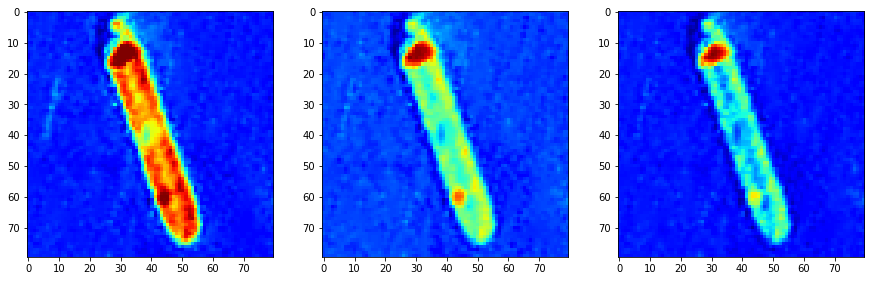

In [7]:
# Visualize
pic=X[0]
red_chanel=pic[0]
green_chanel=pic[1]
blue_chanel=pic[2]

plt.figure(figsize=(5*3, 5*1))
plt.set_cmap('jet')

plt.subplot(131)
plt.imshow(red_chanel)

plt.subplot(132)
plt.imshow(green_chanel)

plt.subplot(133)
plt.imshow(blue_chanel)

plt.show()

# 3. Binary-Classification Algorithms Comparison

### Split the dataset

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(data_images,data_labels,test_size=0.2,random_state=42)

### Comparison using sklearn

In [ ]:
start=time.time()
def compareABunchOfDifferentModelsAccuracy(a,b,c,d):   
    print('\nCompare Multiple Classifiers:')
    print('\nK-Fold Cross-Validation Accuracy:\n')
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC()))
    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a,b)
        kfold = model_selection.KFold(n_splits=10, random_state=42)
        accuracy_results = model_selection.cross_val_score(model, a,b, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()
    return

compareABunchOfDifferentModelsAccuracy(x_train,y_train,x_test,y_test)

def defineModels():
    print('LR = LogisticRegression')
    print('RF = RandomForestClassifier')
    print('KNN = KNeighborsClassifier')
    print('SVM = Support Vector Machine')
    return
defineModels()
end=time.time()
print(start-end)

# 4. Convolutional Neural Network Implementation

### Data Preprocessing

In [8]:
# Convert data_labels into onehotcode
Y=np_utils.to_categorical(data_labels,2)
print(Y.shape)
print(Y)

(2800, 2)
[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


In [9]:
# Shuffle
indexes = np.arange(2800)
np.random.shuffle(indexes)
X=X[indexes].transpose([0,2,3,1])
Y=Y[indexes]

In [10]:
# Normalization
X=X/255

### Train Convolutional Neural Network

In [11]:
np.random.seed(42)

In [12]:
# Design Network
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))

model.add(Conv2D(32, (9, 9), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))

model.add(Conv2D(32, (9, 9), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [13]:
# Optimization Setup
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-8,decay=0.0,amsgrad=False),
    metrics=['accuracy'])
# training
history=model.fit(
    X,
    Y,
    batch_size=32,
    epochs=32,
    validation_split=0.2,
    shuffle=True,
    verbose=2)

Train on 2240 samples, validate on 560 samples
Epoch 1/8
 - 41s - loss: 0.5025 - acc: 0.7862 - val_loss: 0.3066 - val_acc: 0.8804
Epoch 2/8
 - 37s - loss: 0.2926 - acc: 0.8862 - val_loss: 0.2856 - val_acc: 0.8875
Epoch 3/8
 - 40s - loss: 0.2168 - acc: 0.9129 - val_loss: 0.2029 - val_acc: 0.9250
Epoch 4/8
 - 38s - loss: 0.1793 - acc: 0.9272 - val_loss: 0.1656 - val_acc: 0.9446
Epoch 5/8
 - 39s - loss: 0.1169 - acc: 0.9576 - val_loss: 0.1298 - val_acc: 0.9625
Epoch 6/8
 - 31s - loss: 0.1205 - acc: 0.9540 - val_loss: 0.1374 - val_acc: 0.9464
Epoch 7/8
 - 25s - loss: 0.1085 - acc: 0.9589 - val_loss: 0.1352 - val_acc: 0.9554
Epoch 8/8
 - 25s - loss: 0.0798 - acc: 0.9719 - val_loss: 0.1170 - val_acc: 0.9661


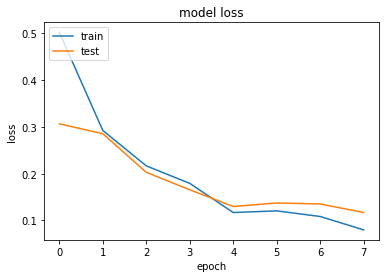

In [14]:
# Plot Loss Curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

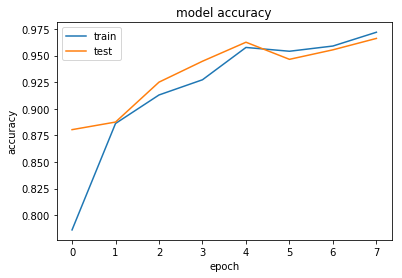

In [15]:
# Plot Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Ship Detection Combining CNN with Sliding Window

### Download image

In [106]:
image=cv2.imread('/Users/howard/Desktop/ECE228/Project/Data/scenes/sfbay_1.png',flags=cv2.IMREAD_COLOR)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

In [107]:
width=image.shape[0]
height=image.shape[1]

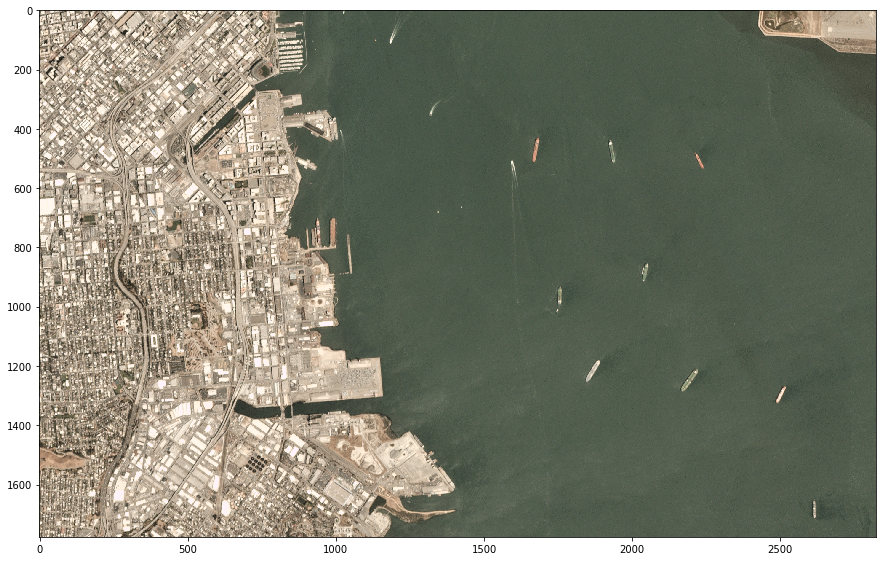

In [108]:
# Visualize
plt.figure(1, figsize = (15, 30))

plt.imshow(image)

plt.show()

In [109]:
image.shape
print(type(image))

<class 'numpy.ndarray'>


In [110]:
image=image.transpose(2,0,1)
image= np.array(image).astype('uint8')

In [111]:
image.shape

(3, 1777, 2825)

### Search on the image

In [112]:
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = image[0][y+i][x+j]
            area_study[1][i][j] = image[1][y+i][x+j]
            area_study[2][i][j] = image[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

In [113]:
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

In [114]:
def show_ship(x, y, acc, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                image[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                image[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                image[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                image[ch][y+th+80][x+i] = -1

X:1150 Y:50  [[ 0.05867222  0.94132781]]


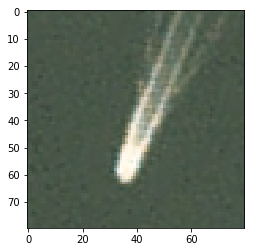

X:300 Y:240   

KeyboardInterrupt: 

In [115]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()

In [39]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

In [40]:
image=image.transpose(1,2,0)
image.shape

(1777, 2825, 3)

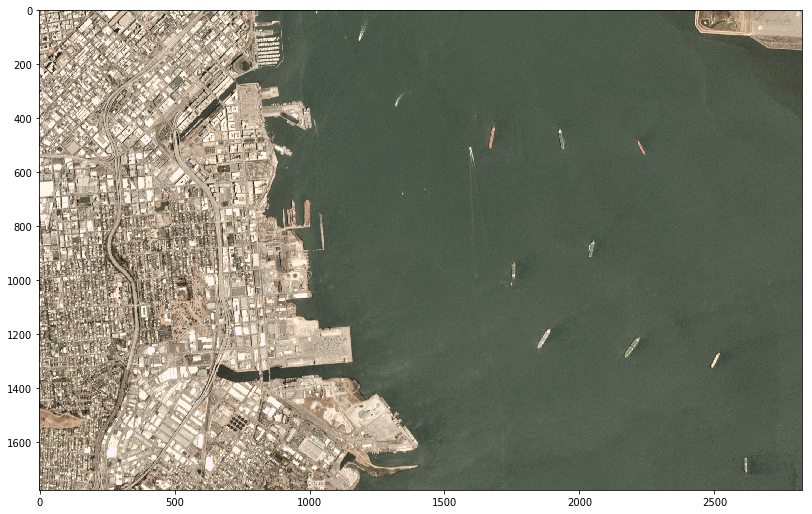

In [41]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(image)

plt.show()